<a href="https://colab.research.google.com/github/gatienc/multimodal_product_data_classification/blob/main/notebooks/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea
### CLIP1:
In this version I am trying to use only image and designation, I'm applying
Explicit Cross-modal Interaction from
[Hate-CLIPper: Multimodal Hateful Meme Classification based on Cross-modal Interaction of CLIP Features](https://arxiv.org/pdf/2210.05916.pdf)

### CLIP2:
diff: added a dropout layer to reduce overfitting


### CLIP3:
diff: if description exists, we get the mean of the features of description &&
added stopword to the description and designation
### CLIP4
diff : preprocess images to be the max size possible so every image are not surrounded by white

current research, do upscale algorithm be better than just a resize of the image, need to find paper on the supject

# Hyperparameters

In [35]:
BATCH_SIZE=128#  8 for 13.8 gb usage, 6 for less than 12 gb usage
NUM_CLASSES=27
SEED=42

CLIP_FEATURE_SIZE=768

#testing
# train_percentage=0.001
# valid_percentage=0.001

train_percentage=0.8
valid_percentage=0.1
#(test_percentage takes the rest)

use_cropped=True

google_colab=True
force_cpu=False


In [36]:
TEXT_EMBEDDING_DIM=300 #cannot be changed or retrain the text model
VOCAB_SIZE=67465

In [37]:
images_name="cropped_images" if use_cropped else "images"
images_name

'cropped_images'

# Imports


In [38]:
%pip install transformers pandas tqdm scikit-learn imageio matplotlib wget plotly dash unidecode tensorflow

In [39]:
from transformers import CLIPProcessor, CLIPModel,CLIPFeatureExtractor
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision

import imageio

from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score

import zipfile
import os
import copy

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from datetime import datetime
import unidecode
from PIL import Image

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [40]:
if google_colab:
    # mount the drive where your dataset is availabledevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    from google.colab import drive
    drive.mount('/content/drive')
    filepath='/content/drive/MyDrive/datasets/multimodal_product_classification/' # add your own path. Where to save the dataset

    if not os.path.exists('datasets'):
        os.makedirs('datasets')
        with zipfile.ZipFile(filepath+images_name+'.zip', 'r') as zip_ref:
            zip_ref.extractall('datasets')



    datasets_path="/content/datasets/"
    save_directory="/content/drive/MyDrive/Lessons/Models/multimodal_classification/"

else:
    import wget
    if not os.path.exists('datasets'):
        os.makedirs('datasets')
        output_directory="datasets"
        csv_zip = wget.download("https://nextcloud.its-tps.fr/s/BTpB4SC93NreZxg/download/csv_data.zip",out=output_directory)
        if use_cropped:
            images_zip=wget.download("https://nextcloud.its-tps.fr/s/8dZMpfpDNnpaZ5P/download/cropped_images.zip",out=output_directory)
        else:
            images_zip=wget.download("https://nextcloud.its-tps.fr/s/fgBxQczEAZ7ws8J/download/images.zip",out=output_directory)
        with zipfile.ZipFile(output_directory+'/csv_data.zip', 'r') as zip_ref:
            zip_ref.extractall('datasets')
        with zipfile.ZipFile(output_directory+'/'+images_name+'.zip', 'r') as zip_ref:
            zip_ref.extractall('datasets')
    filepath=os.getcwd()+'/datasets/'
    save_directory='../models/'
    datasets_path=filepath


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
if force_cpu:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocessing

In [42]:
# Load data
X_train = pd.read_csv(filepath+'X_train.csv').fillna("")
y_train = pd.read_csv(filepath+'Y_train.csv').fillna("")
X_train=X_train.drop(columns="Unnamed: 0")
y_train=y_train.drop(columns="Unnamed: 0")


# Cleaning and Preprocessing Text
CLEANR = re.compile('<.*?>') # delete html tag
def clean_html(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

def clean_text(text):
    text=clean_html(text)
    # Remove special characters and numbers
    text = unidecode.unidecode(text)
    text = re.sub(r'[^a-zA-ZäöüßÄÖÜ ]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply cleaning function to the 'designation' column
X_train['designation'] = X_train['designation'].fillna('').apply(clean_text)
X_train['description'] = X_train['description'].fillna('').apply(clean_text)

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['designation'])
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)# nearly 70 000 of vocab size, it seems too much

67465


In [44]:
encoded_df=pd.get_dummies(y_train, columns=['prdtypecode'])
y_train_categorical = encoded_df.values.tolist()
length=len(y_train_categorical)
y_train_one_hot=pd.DataFrame(np.zeros((length,1),dtype=list),columns=["labels"])
for index,row in tqdm(enumerate(y_train_categorical)):
    y_train_one_hot.loc[index, "labels"]=row
train_df=pd.concat([X_train,y_train_one_hot],axis=1)
train_df

0it [00:00, ?it/s]

,designation,description,productid,imageid,labels
0,olivia personalisiertes notizbuch seiten pu...,,3804725264,1263597046,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,journal des arts le ndeg du lart et son mar...,,436067568,1008141237,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen de marque speedlink est ...,201115110,938777978,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,peluche donald europe disneyland marionnett...,,50418756,457047496,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,la guerre des tuques,luc a des ideacutees de grandeur il veut organ...,278535884,1077757786,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
84911,the sims import anglais,,206719094,941495734,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
84912,kit piscine acier nevada deco pierre o m x m,description complete kit piscine horssol toi p...,3065095706,1188462883,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
84913,journal officiel de la republique francaise nd...,,440707564,1009325617,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
84914,table basse bois de recuperation massif base b...,cette table basse a un design unique et consti...,3942400296,1267353403,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [45]:
y_train

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705
...,...
84911,40
84912,2583
84913,2280
84914,1560


In [46]:
y_train_out=np.argmax(y_train_categorical,1)
y_train_out
label_dict={}
i=0
while len(label_dict)<27:
    key=y_train_out[i]
    if key not in label_dict.keys():
        value=y_train['prdtypecode'][i]
        label_dict[key] = value
    i+=1

label_dict

{0: 10,
 18: 2280,
 2: 50,
 7: 1280,
 25: 2705,
 21: 2522,
 22: 2582,
 13: 1560,
 8: 1281,
 14: 1920,
 19: 2403,
 4: 1140,
 23: 2583,
 6: 1180,
 9: 1300,
 20: 2462,
 5: 1160,
 16: 2060,
 1: 40,
 3: 60,
 12: 1320,
 11: 1302,
 17: 2220,
 26: 2905,
 24: 2585,
 15: 1940,
 10: 1301}


# Data loading

In [47]:
class ImageTextDataLoader(Dataset):
    """Title, Description and Image dataset."""

    def __init__(self, dataframe, image_dir):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
        """
        self.df = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        selected_df=self.df.iloc[idx]

        image_name="image_"+str(selected_df["imageid"])+"_product_"+str(selected_df["productid"])+".jpg"
        filepath=os.path.join(self.image_dir,image_name)
        image_arr = Image.open(filepath)
        image_arr = image_arr.resize((224, 224))
        image_arr=np.array(image_arr)




        designation_text=selected_df['designation']
        description_text=selected_df['description']
        if len(description_text)>10:
            description_sequences = tokenizer.texts_to_sequences([description_text])
            # Padding to max length of text
            description = pad_sequences(description_sequences, maxlen=34)

        else :description=np.zeros((1,34))
        description=torch.from_numpy(description).to(device, dtype=int)

        designation_sequences = tokenizer.texts_to_sequences([designation_text])
        # Padding to max length of text

        designation =pad_sequences(designation_sequences, maxlen=34)
        designation = torch.from_numpy(designation).to(device, dtype=int)
        label=torch.tensor(selected_df['labels'], dtype=torch.float,device=device)

        return [designation,description,image_arr,label]


In [48]:
if use_cropped==True:
    dataset=ImageTextDataLoader(train_df,datasets_path+"cropped_images/cropped_train")
else:
    dataset=ImageTextDataLoader(train_df,datasets_path+"/images/image_train")


In [49]:
train_size = int(train_percentage * len(dataset))
valid_size = int(valid_percentage * len(dataset))
test_size = len(dataset) - train_size - valid_size

generator = torch.Generator().manual_seed(SEED)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size],generator=generator)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


dataloaders={
    'train':train_dataloader,
    'val':valid_dataloader,
    'test':test_dataloader
    }


# text model def

In [50]:

# Define the model
class Text_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(Text_model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_blocks = nn.ModuleList([
            nn.Conv2d(1, 512, (i, embedding_dim), padding=(0, 0))
            for i in range(1,7)
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * 6, CLIP_FEATURE_SIZE)
        self.classif=nn.Linear(CLIP_FEATURE_SIZE,num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add channel dimension for Conv2d
        conv_outputs = [nn.functional.relu(conv_block(x)).max(dim=3)[0].max(dim=2)[0] for conv_block in self.conv_blocks]# [0] to get only the values and not the indices ( in pos 1 )
        x = torch.cat(conv_outputs, dim=1)
        # Dense Layer

        # Flatten Layer
        x = x.view(x.size(0), -1)
        # Dropout Layer
        x = self.dropout(x)

        x = self.fc(x)
        x = self.classif(x)
        return x


In [52]:
text_model = Text_model(VOCAB_SIZE, TEXT_EMBEDDING_DIM, NUM_CLASSES)
saved_state_dict = torch.load(filepath+"Text_model_val_f1_0.747_epoch6.ckpt")
text_model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [53]:
text_model.classif = nn.Sequential()#delete the classification head
text_model.to(device)
text_model.eval()

Text_model(
  (embedding): Embedding(67465, 300)
  (conv_blocks): ModuleList(
    (0): Conv2d(1, 512, kernel_size=(1, 300), stride=(1, 1))
    (1): Conv2d(1, 512, kernel_size=(2, 300), stride=(1, 1))
    (2): Conv2d(1, 512, kernel_size=(3, 300), stride=(1, 1))
    (3): Conv2d(1, 512, kernel_size=(4, 300), stride=(1, 1))
    (4): Conv2d(1, 512, kernel_size=(5, 300), stride=(1, 1))
    (5): Conv2d(1, 512, kernel_size=(6, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=3072, out_features=768, bias=True)
  (classif): Sequential()
)

In [54]:
Clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336").to(device)
Clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [55]:
def get_images_features(images):
    inputs = Clip_processor(images=images, return_tensors="pt").to(device)
    image_features = Clip_model.get_image_features(**inputs).to(device)
    del inputs
    return(image_features)

# Model Definition

In [56]:
print(Clip_model.device)

cuda:0


In [57]:
class ClassificationHead(nn.Module):
   def __init__(self, input_dim, num_classes):
       super(ClassificationHead, self).__init__()

       self.head=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(input_dim,128),
            nn.ReLU(),
            nn.Linear(128,num_classes),
       )

   def forward(self, x):
       x = self.head(x)
       return (x)


In [58]:
model=ClassificationHead(CLIP_FEATURE_SIZE**2,NUM_CLASSES).to(device)

criterion = torch.nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [59]:
def calculate_weighted_f1_score(y_true, y_pred):
  return f1_score(y_true, y_pred, average='weighted')

In [60]:
@torch.no_grad
def eval_model(model,eval_dataloader):
    preds_list=[]
    model.eval()
    # Iterate over data.
    loop_on_eval_dataloader=tqdm(eval_dataloader,position=1,leave=False,ncols=800)
    for designation,description,image_arr,labels in loop_on_eval_dataloader:
        description_features=[]
        with torch.no_grad():
            for i in range(len(description)):
            #get the description that are not null
                if torch.count_nonzero(description[i])>0:
                    description_feature=text_model(description[i])
                    description_features.append(description_feature.T)
                else:
                    description_features.append([])
            images_features=get_images_features(image_arr).unsqueeze(2)
            designation_features=text_model(designation.squeeze(1)).unsqueeze(2)

            if len(description_features[0])>0:
                designation_features[0]=(designation_features[0]+description_features[0])/2


            #HERE implement fusion model of designation, description and image_arr
            input_features=torch.matmul(images_features[0], designation_features[0].T).flatten().to(device).unsqueeze(0)


            for i in range(1,images_features.size(dim=0)):
                # Perform the multiplication and append the result to the results array
                if len(description_features[i])>0:

                    designation_features[i]=(designation_features[i]+description_features[i])/2

                feature_interaction_matrix=torch.matmul(images_features[i], designation_features[i].T)
                input_feature=(feature_interaction_matrix).flatten().to(device)

                input_features = torch.cat((input_features, input_feature.unsqueeze(0)), dim=0)


            preds = model(input_features)
            preds_list.append(preds)

    return preds_list

In [61]:
preds=eval_model(model,test_dataloader)

  0%|                                                                                                         …

In [75]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [76]:
def switch_labels(label):
    val=label_dict[label]
    return(val)

In [77]:
y_true = []
for i in test_dataloader:
    for vec in i[3]:
        y_true.append(switch_labels(np.argmax(vec.cpu().numpy())))

y_pred=[]
for pred in preds:
    for e in torch.max(pred,1)[1].tolist():
        y_pred.append(switch_labels(e))


In [78]:
print(len(y_pred))
print(len(y_true))

8493
8493


In [79]:
print(max(y_pred))

2905


In [80]:
print(max(y_true))

2905


In [89]:
print(np.sum(y_true==y_pred))

0


In [86]:
np.unique(y_pred)

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905])

In [87]:
np.unique(y_true)

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905])

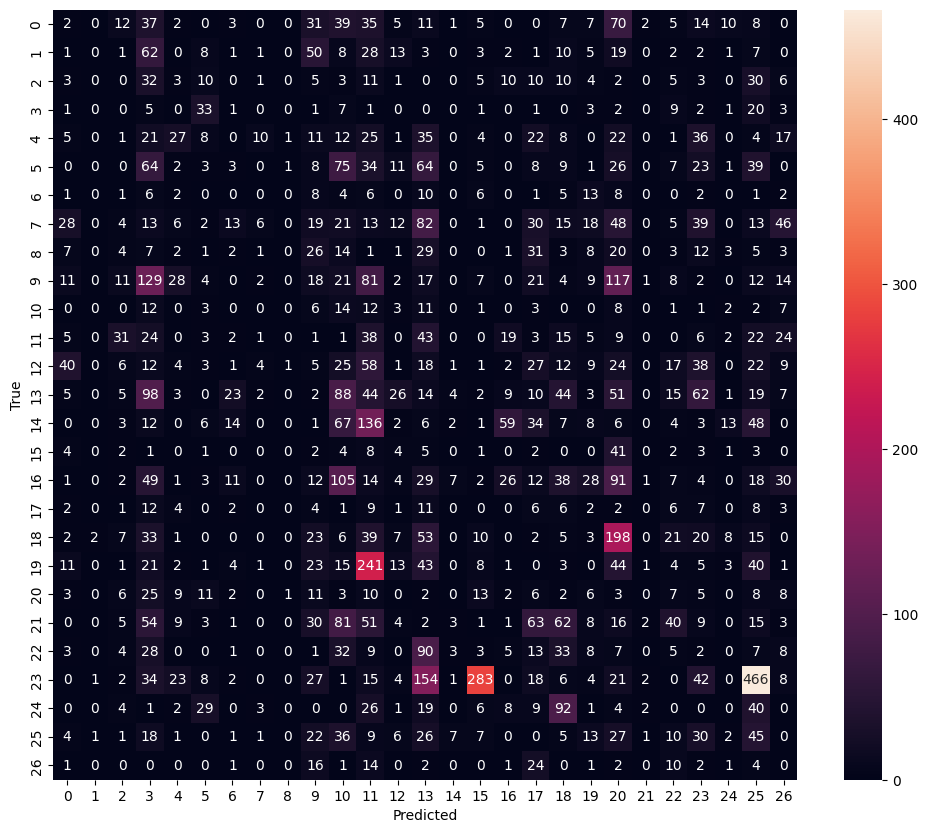

In [88]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()